In [5]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, pchip

/Users/trabbani/opt/anaconda3/envs/tahsml/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [6]:
df = pd.read_pickle("./all_result_v1.pkl")

In [7]:
#Change name if you want analysis on another set.
diffdb = df.loc[df['dataset_name'] == 'mscoco']

In [8]:
diffdb = diffdb.loc[df['eval_setup'] == 'removal']

In [9]:
diffdb

,eval_setup,dataset_name,source_name,attack_name,attack_strength,acc_1,auc_1,low100_1,low1000_1,legacy_fid,clip_fid,psnr,ssim,nmi,lpips,watson,aesthetics,artifacts,clip_score
768,removal,mscoco,stable_sig,2x_regen,20.0,0.5473,0.563038,0.0042,0.0002,"(3.6269043217214403, 0.0)","(0.4339718917056814, 0.0)","(23.756238885913067, 2.49392328558418)","(0.7338627107013358, 0.09565003662559737)","(1.213062285876599, 0.05303427024230886)","(0.10270764091424645, 0.03311463359471984)","(1310295.8251875, 5317792.92080666)","(0.16220839810371399, 0.3060965961326806)","(-0.0528414323925972, 0.17968340179877718)","(-0.0004905804297886788, 0.007439081945954622)"
770,removal,mscoco,stable_sig,4x_regen,20.0,0.5131,0.496053,0.0016,0.0002,"(7.061729323151553, 0.0)","(1.7048442522209655, 0.0)","(20.977914585907154, 2.1900721279210575)","(0.6434187961682121, 0.10958748329649891)","(1.1682306199819723, 0.04486739417772975)","(0.19577156091853976, 0.05635828814399809)","(1734130.1721875, 1730855.4900442765)","(0.5011486392021179, 0.4132734176814006)","(-0.23251286804676055, 0.241606293572589)","(-0.0012179895548615604, 0.010148474802778825)"
771,removal,mscoco,stable_sig,2x_regen,60.0,0.5211,0.514744,0.0020,0.0004,"(8.93318321876683, 1.7763568394002505e-15)","(1.8713308868885432, 2.220446049250313e-16)","(21.761704238351555, 2.390797251712622)","(0.6527983011120206, 0.10760429267096196)","(1.170492753843896, 0.04399838383323141)","(0.17551897890493273, 0.04611805969689319)","(1390379.61740625, 917511.938368148)","(0.3186305220127106, 0.40704268772077545)","(-0.1927205901145935, 0.23925636675686696)","(-0.00048190954560413954, 0.009733650511577818)"
772,removal,mscoco,stable_sig,2x_regen,40.0,0.5151,0.512891,0.0044,0.0002,"(13.338112039458963, 0.0)","(3.3499251402179344, 4.440892098500626e-16)","(22.004983770068524, 2.3316496790838084)","(0.6595367392757429, 0.10155715606733702)","(1.172022934856926, 0.04236966144670764)","(0.19044839818030596, 0.04735619208462306)","(1983906.11246875, 16136128.078569498)","(0.3961449410915375, 0.45631197527590367)","(-0.2683059200644493, 0.26970619736206064)","(-0.0003153506508097053, 0.010809616470388273)"
773,removal,mscoco,stable_sig,2x_regen,80.0,0.5101,0.500850,0.0022,0.0004,"(8.59110611680444, 0.0)","(1.7073988293502396, 0.0)","(21.375177165604317, 2.416735955981095)","(0.6364565205355962, 0.11214709363809502)","(1.165002804353419, 0.04387703331060352)","(0.17855776996910572, 0.045882014300184334)","(24123318.62209375, 716961186.8815088)","(0.3152249953746796, 0.42202414777338154)","(-0.1869936491250992, 0.2501225737056884)","(-0.001168279035598971, 0.009843171741897031)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,removal,mscoco,tree_ring,regen_diffusion_prompt,120.0,0.9339,0.980897,0.7968,0.5598,"(6.108321116464026, 0.0)","(1.2314445501763203, 0.0)","(22.106439677258802, 2.7889287679704236)","(0.6692448995272706, 0.11706908062383149)","(1.175653956418748, 0.051359756730739094)","(0.14003099029324947, 0.039934588661735555)","(1283583.62778125, 1074565.211202924)","(0.33175895786285403, 0.38952189664624143)","(-0.1808100393116474, 0.21960815486058946)","(-0.0007770718429237604, 0.009773265340687252)"
1158,removal,mscoco,tree_ring,regen_vae,7.0,0.9995,0.999999,1.0000,0.9998,"(1.7221862314808618, 0.0)","(0.4629202018507925, 0.0)","(37.05677606113885, 2.250006599672165)","(0.9658096561839443, 0.014905015972252342)","(1.4521404619889355, 0.057167037586643224)","(0.03267163846211042, 0.03154921967666032)","(409535.889046875, 526865.7549215804)","(0.014350980043411255, 0.2375575692555175)","(-0.054460348457098004, 0.15858577465587798)","(-0.0020581908118911087, 0.006995478659304295)"
1159,removal,mscoco,tree_ring,regen_vae,1.0,0.8843,0.953315,0.6442,0.4224,"(26.509018093557643, 0.0)","(5.13948775521348, 0.0)","(26.959217745474955, 2.4967433712476534)","(0.7818582973679825, 0.08711602420212235)","(1.2495379278164218, 0.05026432231608022)","(0.26942628218606113, 0.112514332586337

In [10]:
#Tree-Ring dataframe.
#Change value if you want to try a different watermark. 
tree_ring = diffdb.loc[df['source_name'] == 'tree_ring']

In [11]:
metric_keys=['legacy_fid','clip_fid','psnr','ssim','nmi','lpips','aesthetics','artifacts']

In [15]:
def tpr_quality(df,metrics):
    dic={}
    for m in metrics:
        dic[m]=[]
        for ind in df.index:
            dic[m].append((df['low1000_1'][ind],df[m][ind][0]))
    for key in dic:
        dic[key]=sorted(dic[key], key=lambda k: [k[0], k[1]])
    return dic

def tpr_interp(dic):
    #interp_dic={}
    interp_dic=[]
    for key in dic:
        x_coord=[dic[key][j][0] for j in range(len(dic[key]))]
        y_coord=[dic[key][j][1] for j in range(len(dic[key]))]
        f = interp1d(x_coord, y_coord,kind='nearest',fill_value='extrapolate')
        if np.min(x_coord)>0.8:
            if key == 'psnr':
                interp_dic.append(np.inf)
            elif key == 'ssim':
                interp_dic.append(np.inf)
            else:
                interp_dic.append(-1*np.inf)
        else:        
            interp_dic.append(-1*float(f(0.8)))
    return interp_dic

In [16]:
ATTACK_NAMES = [
    "distortion_combo_geometric",
    "distortion_combo_photometric",
    "distortion_combo_degradation",
    "regen_diffusion",
    "2x_regen",
    #"4x_regen_kl_vae",
    "adv_emb_clip_untg_alphaRatio_0.05_step_200",
    "adv_emb_same_vae_untg",
    "adv_emb_klf16_vae_untg",
    "adv_cls_wm1_wm2_0.01_50_warm",
    ]

In [18]:
full_metrics={}
for attack in ATTACK_NAMES:
    sub_df = tree_ring.loc[df['attack_name'] == attack]
    sub_df_dic = tpr_quality(sub_df,metric_keys)
    full_metrics[attack]=tpr_interp(sub_df_dic)

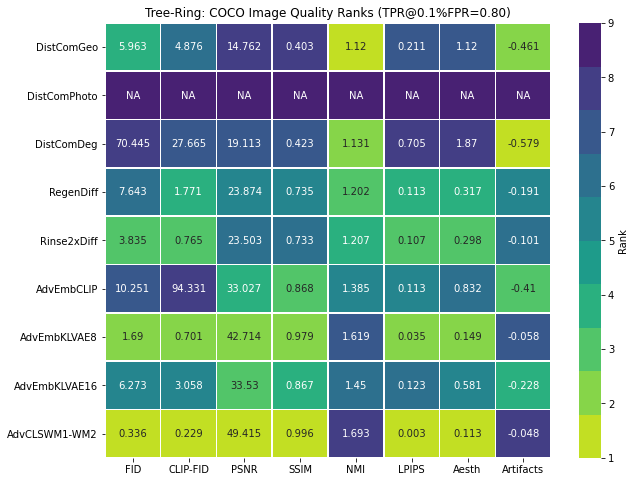

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define your rows and columns
rows = [
    "DistComGeo",
    "DistComPhoto",
    "DistComDeg",
    "RegenDiff",
    "Rinse2xDiff",
    #"Rinse4xDiff",
    #"RegenDKLVAE",
    "AdvEmbCLIP",
    "AdvEmbKLVAE8",
    "AdvEmbKLVAE16",
    "AdvCLSWM1-WM2"
]

cmap = ListedColormap(sns.color_palette("viridis_r", n_colors=10))

columns = ['FID', 'CLIP-FID', 'PSNR', 'SSIM', 'NMI', 'LPIPS', 'Aesth', 'Artifacts']

# Create a sample data frame (you should replace this with your actual data)
data = [full_metrics["distortion_combo_geometric"],
        full_metrics["distortion_combo_photometric"],
        full_metrics["distortion_combo_degradation"],
        full_metrics["regen_diffusion"],
        full_metrics["2x_regen"],
        #full_metrics["4x_regen_kl_vae"],
        full_metrics["adv_emb_clip_untg_alphaRatio_0.05_step_200"],
        full_metrics["adv_emb_same_vae_untg"],
        full_metrics["adv_emb_klf16_vae_untg"],
        full_metrics["adv_cls_wm1_wm2_0.01_50_warm"]]

#Annotations, needs special handling for 'NA'.
annots = -1*np.asarray(data)
annots = np.round(annots,decimals = 3)
annots = annots.astype('str')
for i in range(np.shape(annots)[0]):
    for j in range(np.shape(annots)[1]):
        if annots[i][j]=='inf' or annots[i][j]=='-inf':
            annots[i][j]='NA'
# Create a DataFrame
dataf = pd.DataFrame(data, index=rows, columns=columns)

# Define which columns should be ranked in ascending order
columns_ascending = ['SSIM', 'PSNR']

# Rank each row based on the ordering of the data values
df_ranked = dataf.apply(lambda x: x.rank(ascending=(x.name in columns_ascending)), axis=0)

df_combined = dataf.astype(str) +': '+ df_ranked.astype(int).astype(str)
# Create a custom annotation function
def annotate_heatmap(val):
    return f'{val}\n{df.stack().rank().astype(int).loc[val]:d}'
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df_ranked, annot=annots, linewidths=.5, 
            cbar_kws={'ticks': range(1, 10),'label':'Rank'}, cmap=cmap,fmt = '')
#sns.heatmap(df_ranked, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Tree-Ring: COCO Image Quality Ranks (TPR@0.1%FPR=0.80)')
plt.savefig("tree-ring-heatmap.png")
plt.show()